In [1]:
import os
import json
import torch
import clip
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torch import nn, optim
import matplotlib.pyplot as plt

In [2]:
# Dataset
class FashionDataset(Dataset):
    def __init__(self, img_dir, styles_dir, transform=None):
        self.img_dir = img_dir
        self.styles_dir = styles_dir
        self.transform = transform
        self.images = []
        self.descriptions = []
        self.labels = []

        for img_file in os.listdir(self.img_dir):
            if img_file.endswith(".jpg"):
                img_path = os.path.join(self.img_dir, img_file)
                json_path = os.path.join(self.styles_dir, img_file.replace('.jpg', '.json'))
                if os.path.exists(json_path):
                    with open(json_path, 'r') as f:
                        style_data = json.load(f)
                    description = style_data.get("data", {}).get("productDescriptors", {}).get("description", {}).get("value", '')
                    category = style_data.get("data", {}).get("subCategory", {}).get("typeName", '')
                    
                    self.images.append(img_path)
                    self.descriptions.append(description)
                    self.labels.append(category)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        description = self.descriptions[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        return image, description, label

In [3]:
# Define a custom head for classification
class CustomCLIP(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(CustomCLIP, self).__init__()
        self.clip_model = clip_model
        self.fc = nn.Linear(self.clip_model.visual.output_dim, num_classes)

    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images).float()
        outputs = self.fc(image_features)
        return outputs

In [4]:
# Load CLIP model and preprocess
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [5]:
# Prepare dataset
img_dir = "./data/fashion-dataset/images/"
styles_dir = "./data/fashion-dataset/styles/"
dataset = FashionDataset(img_dir, styles_dir, transform=preprocess)

In [6]:
# # display a transformed image
# transformed_image, description, label = dataset[0]
# transformed_image = transformed_image.permute(1, 2, 0).numpy() 
# plt.imshow(transformed_image)
# plt.show()


In [7]:
# Split the dataset into training and validation sets
train_size = int(0.08 * len(dataset))
val_size = int(0.02 * len(dataset))
remain_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, remain_dataset = random_split(dataset, [train_size, val_size, remain_size], generator=torch.Generator().manual_seed(123))

# train_dataset = torch.utils.data.Subset(train_dataset, list(range(500))) 
# val_dataset = torch.utils.data.Subset(val_dataset, list(range(100)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print("Train size: ", train_size, ", Val size: ", val_size)


Train size:  3555 , Val size:  888


In [8]:
# Initialize the model with the number of classes
num_classes = len(set(dataset.labels))
model = CustomCLIP(model, num_classes).to(device)

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
set(dataset.labels)

# Create a label-to-index mapping
unique_labels = list(set(dataset.labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

In [10]:
# Lists to store accuracy values for plotting
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for images, _, labels in train_loader:
        images = images.to(device)
        labels = torch.tensor([label_to_index[label] for label in labels]).to(device)
        # print("image shape: ", images.shape)
        # print("labels: ", labels.shape, "\n, labels: ", labels)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)

    train_accuracy = correct_predictions / total_predictions
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, _, labels in val_loader:
            images = images.to(device)
            # labels = torch.tensor([dataset.labels.index(label) for label in labels]).to(device)
            labels = torch.tensor([label_to_index[label] for label in labels]).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)

    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {running_loss/train_size:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss/val_size:.4f}, Val Accuracy: {val_accuracy:.4f}")

print("Training complete.")

Epoch [1/30], Train Loss: 0.1058, Train Accuracy: 0.1525, Val Loss: 0.0893, Val Accuracy: 0.3660
Epoch [2/30], Train Loss: 0.0777, Train Accuracy: 0.5103, Val Loss: 0.0676, Val Accuracy: 0.5304
Epoch [3/30], Train Loss: 0.0604, Train Accuracy: 0.5668, Val Loss: 0.0549, Val Accuracy: 0.5766
Epoch [4/30], Train Loss: 0.0502, Train Accuracy: 0.6264, Val Loss: 0.0467, Val Accuracy: 0.6441
Epoch [5/30], Train Loss: 0.0430, Train Accuracy: 0.6821, Val Loss: 0.0406, Val Accuracy: 0.7140
Epoch [6/30], Train Loss: 0.0377, Train Accuracy: 0.7516, Val Loss: 0.0358, Val Accuracy: 0.7669
Epoch [7/30], Train Loss: 0.0336, Train Accuracy: 0.7871, Val Loss: 0.0318, Val Accuracy: 0.7950
Epoch [8/30], Train Loss: 0.0300, Train Accuracy: 0.8217, Val Loss: 0.0286, Val Accuracy: 0.8232
Epoch [9/30], Train Loss: 0.0271, Train Accuracy: 0.8383, Val Loss: 0.0259, Val Accuracy: 0.8435
Epoch [10/30], Train Loss: 0.0248, Train Accuracy: 0.8529, Val Loss: 0.0237, Val Accuracy: 0.8559
Epoch [11/30], Train Loss: 0.

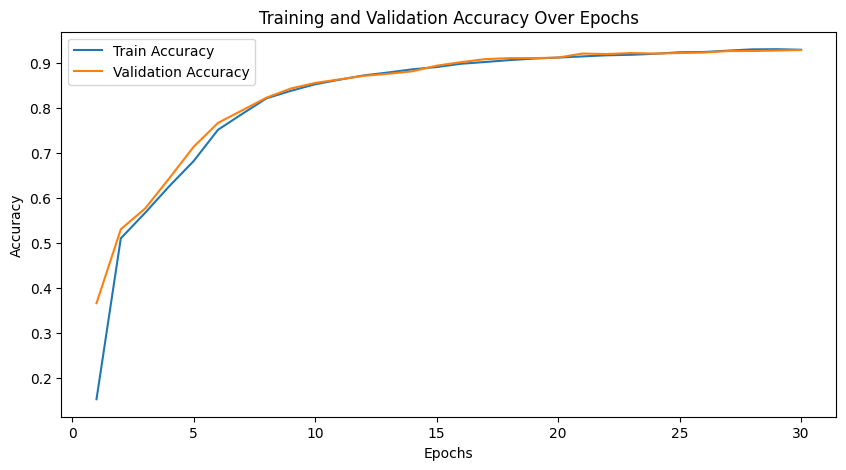

In [12]:
# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()